In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# set default plot params
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.sans-serif'] = 'Tahoma'

import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

from regressors import stats as reg_stats

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))


In [2]:
# read in the data
imdb_df = pd.read_csv('top_gross_films_clean.csv')

# name the dataframe columns
imdb_df.columns = ['index', 'rank', 'title', 'world_lifetime_gross', 'studio', 'domestic_opening_gross', \
                   'budget', 'MPAA_rating', 'run_time', 'genre_list', 'lead_name', 'lead_height_m',\
                   'lead_is_female', 'audience_score', 'tomatometer', 'international_movie', 'lead_age_years']

imdb_df.drop(['index', 'rank'], axis=1, inplace=True)

imdb_df = imdb_df.loc[imdb_df['world_lifetime_gross'] <= 2e9,:]


In [3]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1996 entries, 4 to 1999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   title                   1996 non-null   object 
 1   world_lifetime_gross    1996 non-null   int64  
 2   studio                  1996 non-null   object 
 3   domestic_opening_gross  1996 non-null   float64
 4   budget                  1996 non-null   float64
 5   MPAA_rating             1914 non-null   object 
 6   run_time                1996 non-null   float64
 7   genre_list              1996 non-null   object 
 8   lead_name               1996 non-null   object 
 9   lead_height_m           1979 non-null   float64
 10  lead_is_female          1996 non-null   bool   
 11  audience_score          1996 non-null   float64
 12  tomatometer             1996 non-null   float64
 13  international_movie     1996 non-null   bool   
 14  lead_age_years          1996 non-null   

### Pair plot and heatmap with some possible features

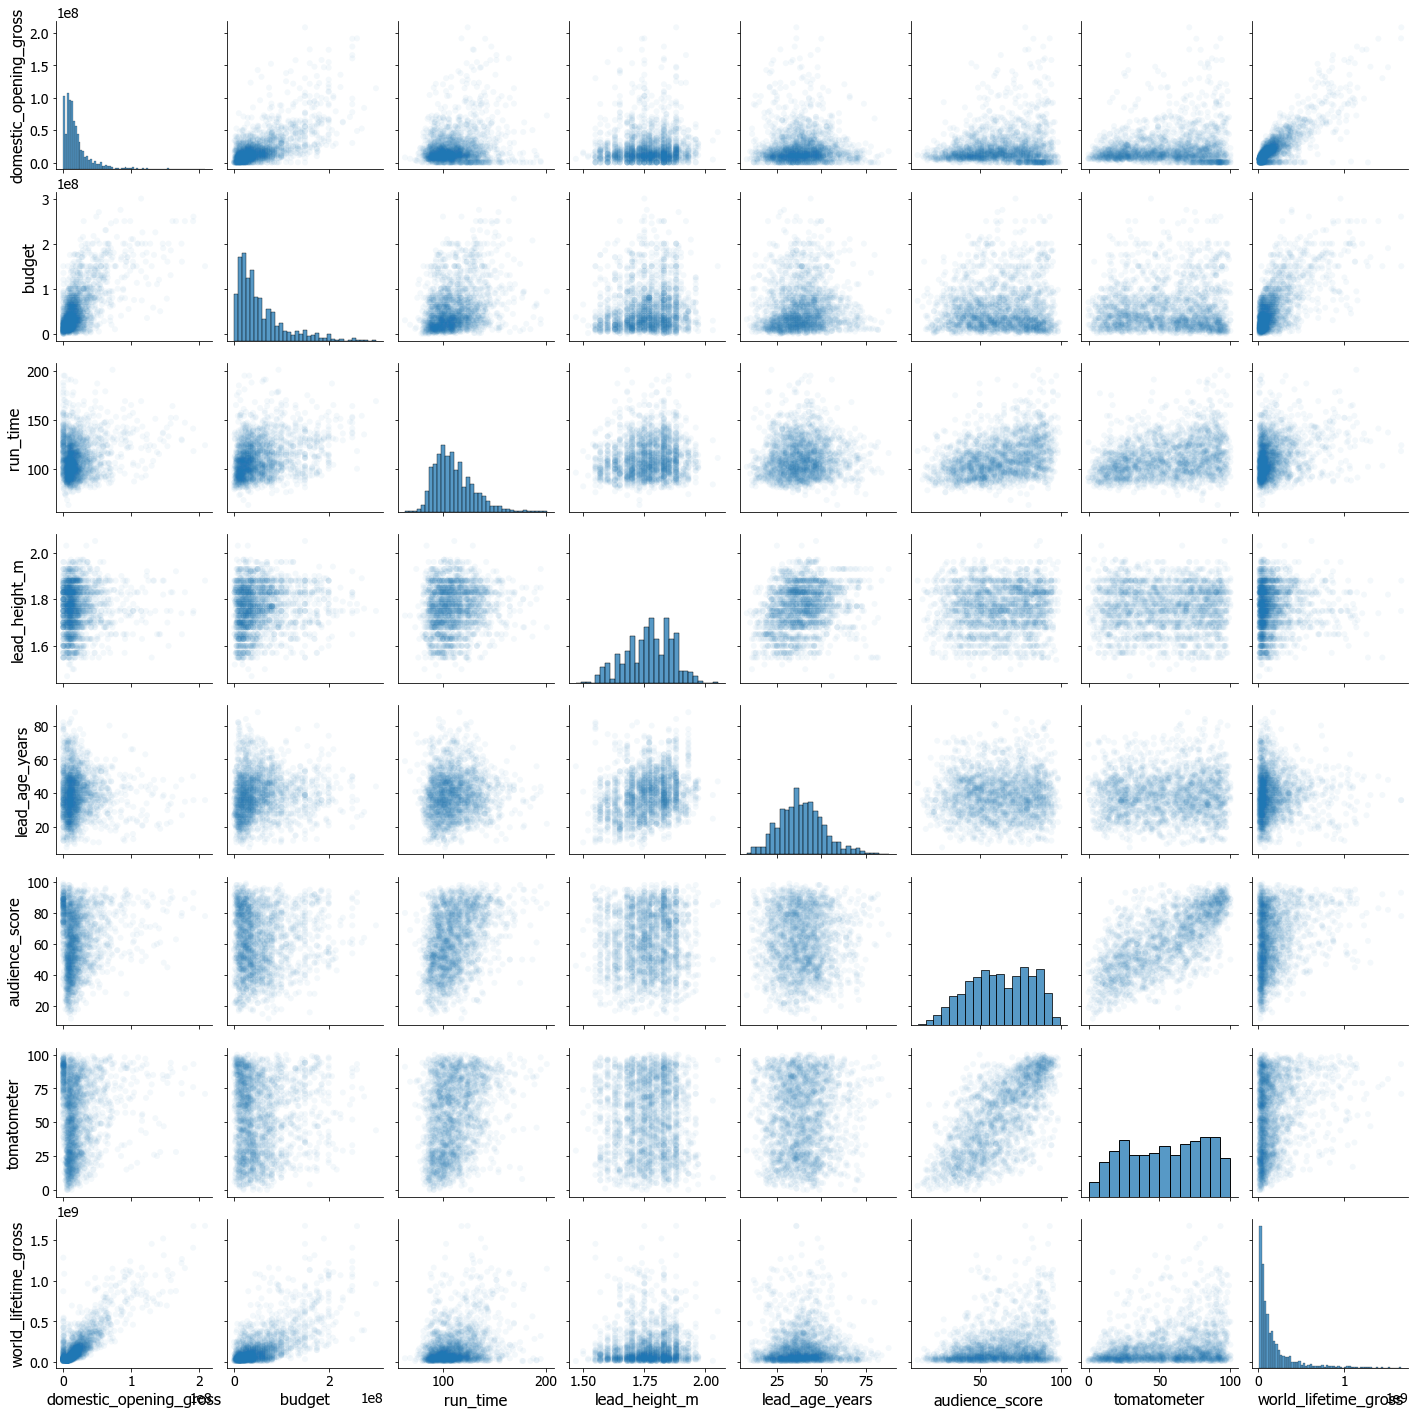

In [4]:
sns.pairplot(imdb_df[['domestic_opening_gross', 'budget', 'run_time',
                       'lead_height_m', 'lead_age_years', 
                       'audience_score', 'tomatometer',
                       'world_lifetime_gross']], plot_kws=dict(alpha=0.05, edgecolor='none'));


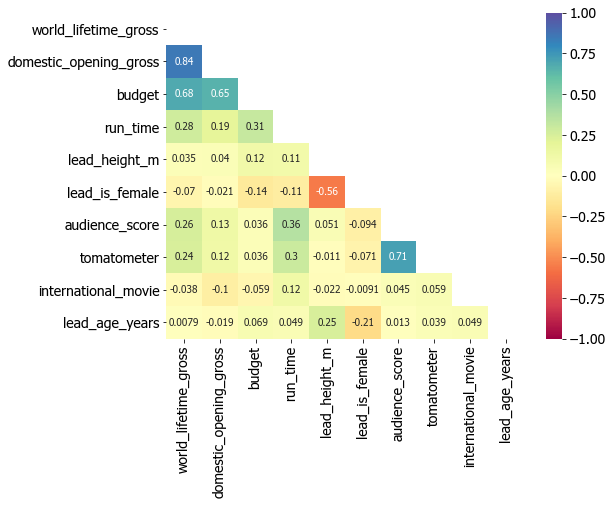

In [5]:
upper = np.triu(imdb_df.corr())  # just look at the lower triangle
plt.figure(figsize=(8,6))
sns.heatmap(imdb_df.corr(), cmap='Spectral', annot=True, vmin=-1, vmax=1, mask=upper);


### Feature engineering

In [6]:
imdb_df['domestic_opening_gross_sq'] = imdb_df['domestic_opening_gross']**2
imdb_df['log_world_lifetime_gross'] = np.log10(imdb_df['world_lifetime_gross'])
imdb_df['log_domestic_opening_gross'] = np.log10(imdb_df['domestic_opening_gross'])
imdb_df['log_budget'] = np.log10(imdb_df['budget'])

gender_dummies = pd.get_dummies(imdb_df['lead_is_female'], drop_first=True)
imdb_df['lead_is_female'] = gender_dummies

international_dummies = pd.get_dummies(imdb_df['international_movie'], drop_first=True)
imdb_df['international_movie'] = international_dummies

imdb_df.head()


,title,world_lifetime_gross,studio,domestic_opening_gross,budget,MPAA_rating,run_time,genre_list,lead_name,lead_height_m,lead_is_female,audience_score,tomatometer,international_movie,lead_age_years,domestic_opening_gross_sq,log_world_lifetime_gross,log_domestic_opening_gross,log_budget
4,Jurassic World,1670516444,Universal Pictures,208806270.0,150000000.0,PG-13,124.0,Action Adventure Sci-Fi,Chris Pratt,1.88,0,78.0,71.0,0,35.969884,4.360006e+16,9.222851,8.319744,8.176091
5,The Lion King,1667635327,Walt Disney Studios Motion Pictures,191770759.0,260000000.0,PG,118.0,Adventure Animation Drama Family Musical,Donald Glover,1.75,0,93.0,93.0,0,35.961666,3.677602e+16,9.222101,8.282782,8.414973
6,Furious 7,1515341399,Universal Pictures,147187040.0,190000000.0,PG-13,137.0,Action Adventure Thriller,Vin Diesel,1.82,0,82.0,82.0,0,47.953451,2.166402e+16,9.180510,8.167870,8.278754
7,Frozen II,1450026933,Walt Disney Studios Motion Pictures,130263358.0,150000000.0,PG,103.0,Adventure Animation Comedy Family Fantasy Musical,Kristen Bell,1.55,1,92.0,78.0,0,39.006168,1.696854e+16,9.161376,8.114822,8.176091
8,Avengers: Age of Ultron,1402809540,Walt Disney Studios Motion Pictures,191271109.0,250000000.0,PG-13,141.0,Action Adventure Sci-Fi,Robert Downey Jr.,1.74,0,83.0,76.0,0,50.047912,3.658464e+16,9.146999,8.281649,8.397940


### Select initial features for test models

In [7]:
target = 'world_lifetime_gross'
feats = ['domestic_opening_gross', 'budget', 'tomatometer', 'audience_score', 'domestic_opening_gross_sq']

X, X_test, y, y_test = train_test_split(imdb_df[feats], imdb_df[target], test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)


### Testing linear regression, polynomial regression, ridge regression, and LASSO models

In [8]:
# Linear model
print('Simple Linear Model\n')

lr = LinearRegression()

scores = cross_val_score(lr, X_train, y_train, cv=kfold)
#print('Linear Reg Scores: ', scores)
print('Linear Reg Mean Score: ', np.mean(scores))

lr.fit(X_train, y_train)

print('Linear Reg Val Score: ', lr.score(X_val, y_val))
print('Linear Reg Val MAE: ', mae(y_val, lr.predict(X_val)))

#list(zip(feats, lr.coef_))


Simple Linear Model

Linear Reg Mean Score:  0.7740303682639648
Linear Reg Val Score:  0.7195620283045427
Linear Reg Val MAE:  68508166.71364945


In [9]:
# Linear polynomial model
print('Polynomial Model\n')

poly = PolynomialFeatures(degree=2)

X_train_poly = poly.fit_transform(X_train)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

lr_poly = LinearRegression()

scores = cross_val_score(lr_poly, X_train_poly, y_train, cv=kfold)
#print('Poly Reg Scores: ', scores)
print('Poly Reg Mean Score: ', np.mean(scores))

lr_poly.fit(X_train_poly, y_train)

print('Poly Reg Val Score: ', lr_poly.score(X_val_poly, y_val))
print('Linear Reg Val MAE: ', mae(y_val, lr_poly.predict(X_val_poly)))

#list(zip(feats, lr_poly.coef_))


Polynomial Model

Poly Reg Mean Score:  0.5807769210116207
Poly Reg Val Score:  0.6096519494314588
Linear Reg Val MAE:  87161583.26398325


In [10]:
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)
X_scaled_val = scaler.transform(X_val)


In [11]:
# Ridge Model
print('Ridge Model\n')
print("\t\tTrain\tVal")

alphas = np.logspace(0,3,10)

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_scaled_train,y_train)
    
    print(f"alpha={alpha:.2f}: \t{ridge.score(X_scaled_train, y_train):.4f} \t{ridge.score(X_scaled_val, y_val):.4f}")

#list(zip(feats, ridge.coef_))


Ridge Model

		Train	Val
alpha=1.00: 	0.7861 	0.7197
alpha=2.15: 	0.7861 	0.7198
alpha=4.64: 	0.7861 	0.7199
alpha=10.00: 	0.7859 	0.7203
alpha=21.54: 	0.7856 	0.7207
alpha=46.42: 	0.7844 	0.7210
alpha=100.00: 	0.7816 	0.7206
alpha=215.44: 	0.7760 	0.7185
alpha=464.16: 	0.7626 	0.7112
alpha=1000.00: 	0.7260 	0.6839


In [12]:
# Lasso Model
print('LASSO Model\n')
print("\t\t\tTrain\tVal")

alphas = np.logspace(5,8,10) # not sure why we need such high alphas for regularization to be significant?

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_scaled_train, y_train)
    
    print(f"alpha={alpha:.2f}: \t{lasso.score(X_scaled_train, y_train):.4f} \t{lasso.score(X_scaled_val, y_val):.4f}")


LASSO Model

			Train	Val
alpha=100000.00: 	0.7861 	0.7196
alpha=215443.47: 	0.7861 	0.7196
alpha=464158.88: 	0.7861 	0.7196
alpha=1000000.00: 	0.7860 	0.7197
alpha=2154434.69: 	0.7859 	0.7197
alpha=4641588.83: 	0.7852 	0.7193
alpha=10000000.00: 	0.7818 	0.7166
alpha=21544346.90: 	0.7663 	0.7024
alpha=46415888.34: 	0.7036 	0.6423
alpha=100000000.00: 	0.5360 	0.4889


### Select Ridge model
Why?:
- Polynomial regression performs poorly relative to other models
- LASSO might zero some of the feature coefficients that we care about (for very high alpha), whereas Ridge will just shrink them according to the chosen alpha
- Ridge performs marginally better than the simple linear regression, and we want a model with regularization to avoid over-fitting

### Try Ridge model with log-scaled features

In [13]:
log_target = 'log_world_lifetime_gross'
log_feats = ['log_domestic_opening_gross', 'log_budget', 'audience_score', 'tomatometer']

X_log, X_test_log, y_log, y_test_log = train_test_split(imdb_df[log_feats], imdb_df[log_target], test_size=0.20, random_state=42)
X_train_log, X_val_log, y_train_log, y_val_log = train_test_split(X_log, y_log, test_size=0.25, random_state=42)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)


In [14]:
scaler = StandardScaler()
X_scaled_train_log = scaler.fit_transform(X_train_log)
X_scaled_test_log = scaler.transform(X_test_log)
X_scaled_val_log = scaler.transform(X_val_log)


In [15]:
# Ridge Model, log scaled features
print('Ridge Model (log scaled features)\n')
print("\t\tTrain\tVal")

alphas = np.logspace(0,3,10)

for alpha in alphas:
    ridge_log = Ridge(alpha=alpha)
    ridge_log.fit(X_scaled_train_log, y_train_log)
    
    print(f"alpha={alpha:.2f}: \t{ridge_log.score(X_scaled_train_log, y_train_log):.4f} \t{ridge_log.score(X_scaled_val_log, y_val_log):.4f}")

#list(zip(feats, ridge_log.coef_))


Ridge Model (log scaled features)

		Train	Val
alpha=1.00: 	0.5222 	0.5621
alpha=2.15: 	0.5222 	0.5621
alpha=4.64: 	0.5222 	0.5620
alpha=10.00: 	0.5222 	0.5618
alpha=21.54: 	0.5221 	0.5614
alpha=46.42: 	0.5217 	0.5604
alpha=100.00: 	0.5203 	0.5573
alpha=215.44: 	0.5145 	0.5483
alpha=464.16: 	0.4954 	0.5230
alpha=1000.00: 	0.4452 	0.4639


### Select Ridge model, no log-scaled features
Why?:

- Standard features, i.e., NOT the log scaled features, yield a better R-squared


In [16]:
# Ridge Model
print('Ridge Model\n')

alphas = np.logspace(0,3,500)

ridge_model = RidgeCV(alphas=alphas, cv=kfold)
ridge_model.fit(X_scaled_train, y_train)
#list(zip(feats, ridge_model.coef_))

print('alpha: ', ridge_model.alpha_)

Ridge Model

alpha:  9.549044557518082


### Some initial plots

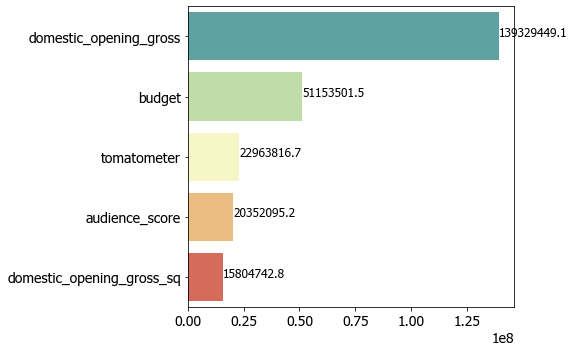

In [17]:
pal = sns.color_palette('Spectral_r', len(ridge_model.coef_))

coef_sorted = sorted(zip(ridge_model.coef_,feats))
xs = np.array([tup[0] for tup in coef_sorted[::-1]])
ys = np.array([tup[1] for tup in coef_sorted[::-1]])

plt.figure(figsize=(8,5))
barp = sns.barplot(y=ys, x=xs, palette=pal)

for p in barp.patches:
    barp.annotate(format(p.get_width(), '.1f'), 
                   (p.get_width(), p.get_y() + p.get_height() / 2.), 
                   ha='left', va='top', 
                   xytext=(0, 9), 
                   textcoords='offset points',
                   fontsize=12)
    
plt.tight_layout()

plt.savefig('figures/ridge_basic_coef.png', dpi=300)


Ridge Reg R2:  0.7859580195318719
Ridge Reg MAE:  65956281.5577697


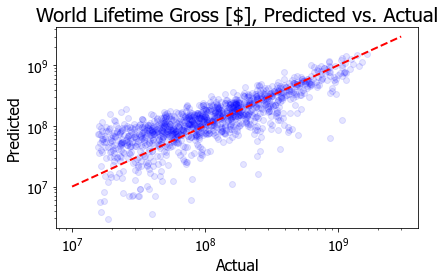

In [18]:
y_train_pred = ridge_model.predict(X_scaled_train)

print('Ridge Reg R2: ', r2_score(y_train, y_train_pred))
print('Ridge Reg MAE: ', mae(y_train, y_train_pred))

plt.scatter(y_train, y_train_pred, alpha=0.1, color='b')
plt.plot(np.arange(1e7, 3e9, 1000), np.arange(1e7, 3e9, 1000), color='r', ls='--')
plt.xscale('log')
plt.yscale('log')

plt.title('World Lifetime Gross [$], Predicted vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()

plt.savefig('figures/ridge_basic.png', dpi=300)


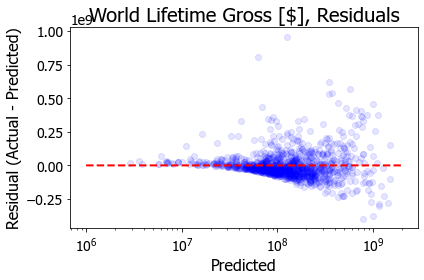

In [19]:
ridge_residuals = y_train - y_train_pred

plt.scatter(y_train_pred, ridge_residuals, alpha=0.1, color='b')
plt.plot(np.arange(1e6, 2e9, 1000), np.zeros(len(np.arange(1e6, 2e9, 1000))), color='r', ls='--')
plt.xscale('log')

plt.title('World Lifetime Gross [$], Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residual (Actual - Predicted)')
plt.tight_layout()

plt.savefig('figures/ridge_basic_resid.png', dpi=300)


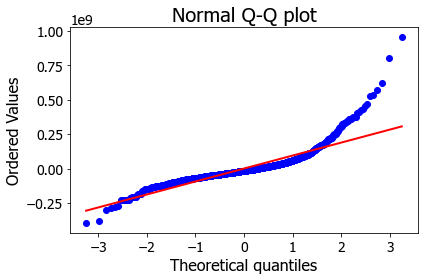

In [20]:
stats.probplot(ridge_residuals, dist='norm', plot=plt)
plt.title('Normal Q-Q plot')
plt.tight_layout()

plt.savefig('figures/ridge_basic_qq.png', dpi=300)


### Add more features (actor demographics) to the model

In [21]:
target = 'world_lifetime_gross'
feats_add = ['domestic_opening_gross', 'budget', 'tomatometer', 'audience_score', 'domestic_opening_gross_sq', 'lead_age_years', 'lead_is_female']

X, X_test, y, y_test = train_test_split(imdb_df[feats_add], imdb_df[target], test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)
X_scaled_val = scaler.transform(X_val)


### Estimate alpha

In [22]:
# Ridge Model
print('Ridge Model\n')

alphas = np.logspace(0,3,500)

ridge_model = RidgeCV(alphas=alphas, cv=kfold)
ridge_model.fit(X_scaled_train, y_train)
#list(zip(feats, ridge_model.coef_))

print('alpha: ', ridge_model.alpha_)


Ridge Model

alpha:  10.233402121916418


In [23]:
print('Ridge Reg Train Score: ', ridge_model.score(X_scaled_train, y_train))
print('Ridge Reg Train MAE: ', mae(y_train, ridge_model.predict(X_scaled_train)))
print('\n')
print('Ridge Reg Val Score: ', ridge_model.score(X_scaled_val, y_val))
print('Ridge Reg Val MAE: ', mae(y_val, ridge_model.predict(X_scaled_val)))


Ridge Reg Train Score:  0.7859935437977739
Ridge Reg Train MAE:  65971625.47012632


Ridge Reg Val Score:  0.7202757198456098
Ridge Reg Val MAE:  68304249.3979407


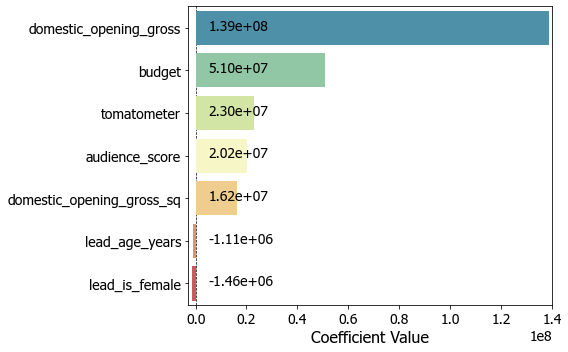

In [24]:
pal = sns.color_palette('Spectral_r', len(ridge_model.coef_))

coef_sorted = sorted(zip(ridge_model.coef_,feats_add))
xs = np.array([tup[0] for tup in coef_sorted[::-1]])
ys = np.array([tup[1] for tup in coef_sorted[::-1]])

plt.figure(figsize=(8,5))
barp = sns.barplot(y=ys, x=xs, palette=pal)

for p in barp.patches:
    barp.annotate(format(p.get_width(), '.2e'), 
                  (0.5e7, p.get_y() + p.get_height() / 2.), 
                  ha='left', va='top', 
                  xytext=(0, 9), 
                  textcoords='offset points',
                  fontsize=14)

plt.axvline(0.0, color='k', ls='--', lw=0.7, zorder=-1)
plt.xlim(-3e6,1.4e8)
plt.xlabel('Coefficient Value')
plt.tight_layout()

plt.savefig('figures/ridge_cv_coef.png', dpi=300)


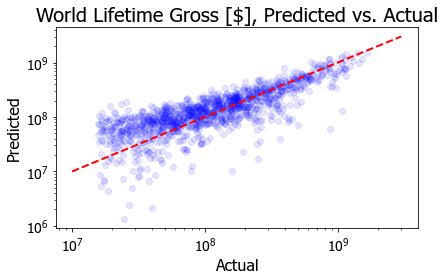

In [25]:
y_train_pred = ridge_model.predict(X_scaled_train)

plt.scatter(y_train, y_train_pred, alpha=0.1, color='b')
plt.plot(np.arange(1e7, 3e9, 1000), np.arange(1e7, 3e9, 1000), color='r', ls='--')
plt.xscale('log')
plt.yscale('log')

plt.title('World Lifetime Gross [$], Predicted vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()

plt.savefig('figures/ridge_cv.png', dpi=300)


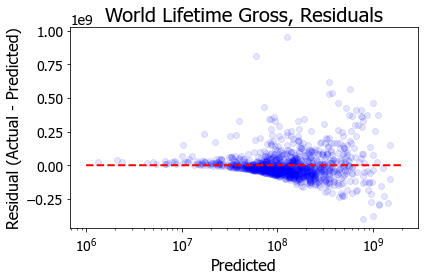

In [26]:
ridge_residuals = y_train - y_train_pred

plt.scatter(y_train_pred, ridge_residuals, alpha=0.1, color='b')
plt.plot(np.arange(1e6, 2e9, 1000), np.zeros(len(np.arange(1e6, 2e9, 1000))), color='r', ls='--')
plt.xscale('log')

plt.title('World Lifetime Gross, Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residual (Actual - Predicted)')
plt.tight_layout()

plt.savefig('figures/ridge_cv_resid.png', dpi=300)


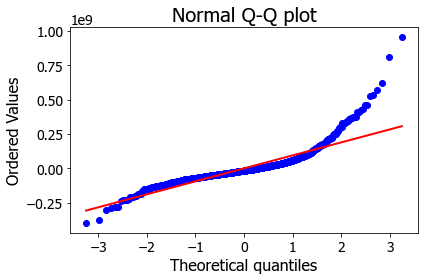

In [27]:
stats.probplot(ridge_residuals, dist='norm', plot=plt)
plt.title('Normal Q-Q plot')
plt.tight_layout()

plt.savefig('figures/ridge_cv_qq.png', dpi=300)


In [28]:
reg_stats.coef_pval(ridge_model, X_scaled_train, y_train)
reg_stats.summary(ridge_model, X_scaled_train, y_train)


Residuals:
          Min           1Q       Median           3Q          Max
-4.748840e+07 7.121276e+07 1.193506e+08 2.162757e+08 1.519491e+09


Coefficients:
                Estimate    Std. Error  t value   p value
_intercept  1.823077e+08  3.031825e+06  60.1313  0.000000
x1          1.389427e+08  7.090155e+06  19.5966  0.000000
x2          5.101627e+07  3.855372e+06  13.2325  0.000000
x3          2.302147e+07  3.993883e+06   5.7642  0.000000
x4          2.021826e+07  3.988235e+06   5.0695  0.000000
x5          1.621449e+07  6.202728e+06   2.6141  0.009059
x6         -1.106723e+06  3.087023e+06  -0.3585  0.720026
x7         -1.455704e+06  3.115128e+06  -0.4673  0.640369
---
R-squared:  0.78599,    Adjusted R-squared:  0.78473
F-statistic: 623.84 on 7 features


### Try adding studio dummies to the model

In [29]:
studio_dummies = pd.get_dummies(imdb_df['studio'], drop_first=True)
imdb_df[studio_dummies.columns] = studio_dummies
imdb_df.drop(['studio'], axis=1, inplace=True)


In [30]:
target = 'world_lifetime_gross'
not_feats = ['world_lifetime_gross', 'title', 'run_time', 'MPAA_rating', 'genre_list', 'lead_name', 'lead_height_m', 'international_movie',  'log_world_lifetime_gross', 'log_domestic_opening_gross', 'log_budget']

X, X_test, y, y_test = train_test_split(imdb_df.drop(not_feats, axis=1), imdb_df[target], test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)
X_scaled_val = scaler.transform(X_val)


In [31]:
# Ridge Model
print('Ridge Model\n')

alphas = np.logspace(0,3,500)

ridge_model = RidgeCV(alphas=alphas, cv=kfold)
ridge_model.fit(X_scaled_train, y_train)
#list(zip(feats, ridge_model.coef_))

print('alpha: ', ridge_model.alpha_)
print('\n')
print('Ridge Reg Train Score: ', ridge_model.score(X_scaled_train, y_train))
print('Ridge Reg Train MAE: ', mae(y_train, ridge_model.predict(X_scaled_train)))
print('\n')
print('Ridge Reg Val Score: ', ridge_model.score(X_scaled_val, y_val))
print('Ridge Reg Val MAE: ', mae(y_val, ridge_model.predict(X_scaled_val)))


Ridge Model

alpha:  13.876647909813085


Ridge Reg Train Score:  0.7912408997719702
Ridge Reg Train MAE:  65148447.49034282


Ridge Reg Val Score:  0.7212700577162408
Ridge Reg Val MAE:  68202537.55053061


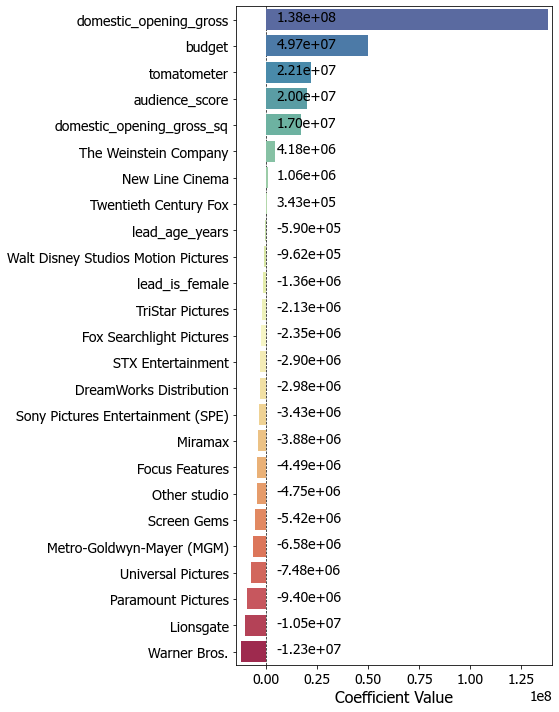

In [32]:
pal = sns.color_palette('Spectral_r', len(ridge_model.coef_))

coef_sorted = sorted(zip(ridge_model.coef_,imdb_df.drop(not_feats, axis=1).columns))
xs = np.array([tup[0] for tup in coef_sorted[::-1]])
ys = np.array([tup[1] for tup in coef_sorted[::-1]])

plt.figure(figsize=(8,10))
barp = sns.barplot(y=ys, x=xs, palette=pal)

for p in barp.patches:
    barp.annotate(format(p.get_width(), '.2e'),
                  (0.5e7, p.get_y() + p.get_height() / 2.), 
                  ha='left', va='top', 
                  xytext=(0, 9), 
                  textcoords='offset points',
                  fontsize=14)

plt.axvline(0.0, color='k', ls='--', lw=0.7, zorder=-1)
plt.xlim(-1.5e7,1.4e8)
plt.xlabel('Coefficient Value')
plt.tight_layout()

plt.savefig('figures/ridge_cv_coef_studio.png', dpi=300)


In [33]:
print(imdb_df.drop(not_feats, axis=1).columns)

Index(['domestic_opening_gross', 'budget', 'lead_is_female', 'audience_score',
       'tomatometer', 'lead_age_years', 'domestic_opening_gross_sq',
       'DreamWorks Distribution', 'Focus Features', 'Fox Searchlight Pictures',
       'Lionsgate', 'Metro-Goldwyn-Mayer (MGM)', 'Miramax', 'New Line Cinema',
       'Other studio', 'Paramount Pictures', 'STX Entertainment',
       'Screen Gems', 'Sony Pictures Entertainment (SPE)',
       'The Weinstein Company', 'TriStar Pictures', 'Twentieth Century Fox',
       'Universal Pictures', 'Walt Disney Studios Motion Pictures',
       'Warner Bros.'],
      dtype='object')


In [34]:
reg_stats.coef_pval(ridge_model, X_scaled_train, y_train)
reg_stats.summary(ridge_model, X_scaled_train, y_train)


Residuals:
          Min           1Q       Median           3Q          Max
-4.640590e+07 6.794837e+07 1.196543e+08 2.146966e+08 1.517221e+09


Coefficients:
                Estimate    Std. Error  t value   p value
_intercept  1.823077e+08  2.994425e+06  60.8824  0.000000
x1          1.381444e+08  7.217468e+06  19.1403  0.000000
x2          4.969651e+07  3.989057e+06  12.4582  0.000000
x3         -1.359931e+06  3.124398e+06  -0.4353  0.663451
x4          1.999498e+07  4.004557e+06   4.9931  0.000001
x5          2.211273e+07  4.048587e+06   5.4618  0.000000
x6         -5.904145e+05  3.068783e+06  -0.1924  0.847466
x7          1.696643e+07  6.285881e+06   2.6991  0.007050
x8         -2.977825e+06  3.400399e+06  -0.8757  0.381354
x9         -4.486576e+06  3.490667e+06  -1.2853  0.198934
x10        -2.353023e+06  3.529549e+06  -0.6667  0.505115
x11        -1.054934e+07  4.247860e+06  -2.4834  0.013148
x12        -6.579086e+06  3.537101e+06  -1.8600  0.063128
x13        -3.884928e+06  3.6

In [35]:
ridge_model_pvals = reg_stats.coef_pval(ridge_model, X_scaled_train, y_train)[1:] # drop the pval for the intercept


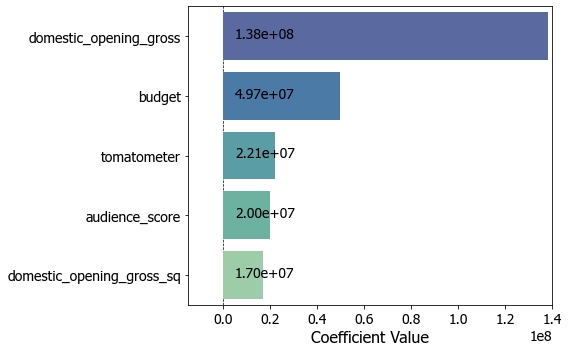

In [36]:
y_pval = imdb_df.drop(not_feats, axis=1).columns
y_pval = y_pval[ridge_model_pvals < 0.01]

x_pval = ridge_model.coef_
x_pval = x_pval[ridge_model_pvals < 0.01]

coef_sorted = sorted(zip(x_pval,y_pval))
x_pval = np.array([tup[0] for tup in coef_sorted[::-1]])
y_pval = np.array([tup[1] for tup in coef_sorted[::-1]])

pal_pval = np.array(pal)[ridge_model_pvals < 0.01]

plt.figure(figsize=(8,5))
barp = sns.barplot(y=y_pval, x=x_pval, palette=pal_pval)

for p in barp.patches:
    barp.annotate(format(p.get_width(), '.2e'),
                  (0.5e7, p.get_y() + p.get_height() / 2.), 
                  ha='left', va='top', 
                  xytext=(0, 9), 
                  textcoords='offset points',
                  fontsize=14)

plt.axvline(0.0, color='k', ls='--', lw=0.7, zorder=-1)
plt.xlim(-1.5e7,1.4e8)
plt.xlabel('Coefficient Value')
plt.tight_layout()

plt.savefig('figures/ridge_cv_coef_studio_trim_significant.png', dpi=300)


### Try adding genre dummies to the model


In [37]:
genres = imdb_df['genre_list'].apply(lambda x: x.split())

mlb = MultiLabelBinarizer()

genre_dummies = pd.DataFrame(mlb.fit_transform(genres), columns=mlb.classes_, index=imdb_df.index)
imdb_df[genre_dummies.columns] = genre_dummies
imdb_df.drop(['genre_list'], axis=1, inplace=True)


In [38]:
for col in genre_dummies.columns:
    print(col, imdb_df[col].sum())
    

Action 680
Adventure 567
Animation 155
Biography 114
Comedy 824
Crime 369
Documentary 11
Drama 878
Family 316
Fantasy 354
History 71
Horror 245
Music 70
Musical 52
Mystery 252
Romance 399
Sci-Fi 331
Sport 74
Thriller 634
War 58
Western 27


In [39]:
imdb_df['Other genre'] = np.zeros(len(imdb_df))

for col in genre_dummies.columns:
    if imdb_df[col].sum() < 100:
        imdb_df['Other genre'] = np.where((imdb_df[col] == 1) | (imdb_df['Other genre'] == 1), 1, 0)
        imdb_df.drop([col], axis=1, inplace=True)
        

In [40]:
imdb_df.head()

,title,world_lifetime_gross,domestic_opening_gross,budget,MPAA_rating,run_time,lead_name,lead_height_m,lead_is_female,audience_score,...,Crime,Drama,Family,Fantasy,Horror,Mystery,Romance,Sci-Fi,Thriller,Other genre
4,Jurassic World,1670516444,208806270.0,150000000.0,PG-13,124.0,Chris Pratt,1.88,0,78.0,...,0,0,0,0,0,0,0,1,0,0
5,The Lion King,1667635327,191770759.0,260000000.0,PG,118.0,Donald Glover,1.75,0,93.0,...,0,1,1,0,0,0,0,0,0,1
6,Furious 7,1515341399,147187040.0,190000000.0,PG-13,137.0,Vin Diesel,1.82,0,82.0,...,0,0,0,0,0,0,0,0,1,0
7,Frozen II,1450026933,130263358.0,150000000.0,PG,103.0,Kristen Bell,1.55,1,92.0,...,0,0,1,1,0,0,0,0,0,1
8,Avengers: Age of Ultron,1402809540,191271109.0,250000000.0,PG-13,141.0,Robert Downey Jr.,1.74,0,83.0,...,0,0,0,0,0,0,0,1,0,0


In [41]:
target = 'world_lifetime_gross'
not_feats = ['world_lifetime_gross', 'title', 'run_time', 'MPAA_rating', 'lead_name', 'lead_height_m', 'international_movie',  'log_world_lifetime_gross', 'log_domestic_opening_gross', 'log_budget']

X, X_test, y, y_test = train_test_split(imdb_df.drop(not_feats, axis=1), imdb_df[target], test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)
X_scaled_val = scaler.transform(X_val)


In [42]:
# Ridge Model
print('Ridge Model\n')

alphas = np.logspace(0,3,500)

ridge_model = RidgeCV(alphas=alphas, cv=kfold)
ridge_model.fit(X_scaled_train, y_train)
#list(zip(feats, ridge_model.coef_))

print('alpha: ', ridge_model.alpha_)
print('\n')
print('Ridge Reg Train Score: ', ridge_model.score(X_scaled_train, y_train))
print('Ridge Reg Train MAE: ', mae(y_train, ridge_model.predict(X_scaled_train)))
print('\n')
print('Ridge Reg Val Score: ', ridge_model.score(X_scaled_val, y_val))
print('Ridge Reg Val MAE: ', mae(y_val, ridge_model.predict(X_scaled_val)))


Ridge Model

alpha:  15.288635880587302


Ridge Reg Train Score:  0.8031702575839981
Ridge Reg Train MAE:  64409751.81740048


Ridge Reg Val Score:  0.7346757277856006
Ridge Reg Val MAE:  67372366.85858458


In [ ]:
upper = np.triu(imdb_df.corr())  # just look at the lower triangle
plt.figure(figsize=(20,20))
sns.heatmap(imdb_df.corr(), cmap='Spectral', annot=True, vmin=-1, vmax=1, mask=upper);


In [ ]:
pal = sns.color_palette('Spectral_r', len(ridge_model.coef_))

coef_sorted = sorted(zip(ridge_model.coef_,imdb_df.drop(not_feats, axis=1).columns))
xs = np.array([tup[0] for tup in coef_sorted[::-1]])
ys = np.array([tup[1] for tup in coef_sorted[::-1]])

plt.figure(figsize=(8,10))
barp = sns.barplot(y=ys, x=xs, palette=pal)

for p in barp.patches:
    barp.annotate(format(p.get_width(), '.2e'),
                  (0.5e7, p.get_y() + p.get_height() / 2.), 
                  ha='left', va='top', 
                  xytext=(0, 9), 
                  textcoords='offset points',
                  fontsize=14)

plt.axvline(0.0, color='k', ls='--', lw=0.7, zorder=-1)
plt.xlim(-1.7e7,1.4e8)
plt.xlabel('Coefficient Value')
plt.tight_layout()

plt.savefig('figures/ridge_cv_coef_studio_genre.png', dpi=300)


In [ ]:
print(imdb_df.drop(not_feats, axis=1).columns)

In [ ]:
reg_stats.coef_pval(ridge_model, X_scaled_train, y_train)
reg_stats.summary(ridge_model, X_scaled_train, y_train)


In [ ]:
ridge_model_pvals = reg_stats.coef_pval(ridge_model, X_scaled_train, y_train)[1:] # drop the pval for the intercept


In [ ]:
y_pval = imdb_df.drop(not_feats, axis=1).columns
y_pval = y_pval[ridge_model_pvals < 0.01]

x_pval = ridge_model.coef_
x_pval = x_pval[ridge_model_pvals < 0.01]

coef_sorted = sorted(zip(x_pval,y_pval))
x_pval = np.array([tup[0] for tup in coef_sorted[::-1]])
y_pval = np.array([tup[1] for tup in coef_sorted[::-1]])

pal_pval = np.array(pal)[ridge_model_pvals < 0.01]

plt.figure(figsize=(8,5))
barp = sns.barplot(y=y_pval, x=x_pval, palette=pal_pval)

for p in barp.patches:
    barp.annotate(format(p.get_width(), '.2e'),
                  (0.5e7, p.get_y() + p.get_height() / 2.), 
                  ha='left', va='top', 
                  xytext=(0, 9), 
                  textcoords='offset points',
                  fontsize=14)

plt.axvline(0.0, color='k', ls='--', lw=0.7, zorder=-1)
plt.xlim(-1.5e7,1.4e8)
plt.xlabel('Coefficient Value')
plt.tight_layout()

plt.savefig('figures/ridge_cv_coef_studio_genre_trim_significant.png', dpi=300)


# Final model (combine training and validation data, score on test data)

In [ ]:
# Ridge Model
print('Ridge Model\n')

X_scaled = scaler.transform(X)

alphas = np.logspace(0,3,500)

ridge_model = RidgeCV(alphas=alphas, cv=kfold)
ridge_model.fit(X_scaled, y)
#list(zip(feats, ridge_model.coef_))

print('alpha: ', ridge_model.alpha_)
print('\n')
print('Ridge Reg Test Score: ', ridge_model.score(X_scaled_test, y_test))
print('Ridge Reg Test MAE: ', mae(y_test, ridge_model.predict(X_scaled_test)))


In [ ]:
pal = sns.color_palette('Spectral_r', len(ridge_model.coef_))

coef_sorted = sorted(zip(ridge_model.coef_,imdb_df.drop(not_feats, axis=1).columns))
xs = np.array([tup[0] for tup in coef_sorted[::-1]])
ys = np.array([tup[1] for tup in coef_sorted[::-1]])

plt.figure(figsize=(8,10))
barp = sns.barplot(y=ys, x=xs, palette=pal)

for p in barp.patches:
    barp.annotate(format(p.get_width(), '.2e'),
                  (0.5e7, p.get_y() + p.get_height() / 2.), 
                  ha='left', va='top', 
                  xytext=(0, 9), 
                  textcoords='offset points',
                  fontsize=14)

plt.axvline(0.0, color='k', ls='--', lw=0.7, zorder=-1)
plt.xlim(-1.7e7,1.4e8)
plt.xlabel('Coefficient Value')
plt.tight_layout()

plt.savefig('figures/ridge_final_coef_studio_genre.png', dpi=300)


In [ ]:
print(imdb_df.drop(not_feats, axis=1).columns)

In [ ]:
reg_stats.coef_pval(ridge_model, X_scaled, y)
reg_stats.summary(ridge_model, X_scaled, y)


In [ ]:
ridge_model_pvals = reg_stats.coef_pval(ridge_model, X_scaled_train, y_train)[1:] # drop the pval for the intercept


In [ ]:
y_pval = imdb_df.drop(not_feats, axis=1).columns
y_pval = y_pval[ridge_model_pvals < 0.01]

x_pval = ridge_model.coef_
x_pval = x_pval[ridge_model_pvals < 0.01]

coef_sorted = sorted(zip(x_pval,y_pval))
x_pval = np.array([tup[0] for tup in coef_sorted[::-1]])
y_pval = np.array([tup[1] for tup in coef_sorted[::-1]])

pal_pval = np.array(pal)[ridge_model_pvals < 0.01]

plt.figure(figsize=(8,5))
barp = sns.barplot(y=y_pval, x=x_pval, palette=pal_pval)

for p in barp.patches:
    barp.annotate(format(p.get_width(), '.2e'),
                  (0.5e7, p.get_y() + p.get_height() / 2.), 
                  ha='left', va='top', 
                  xytext=(0, 9), 
                  textcoords='offset points',
                  fontsize=14)

plt.axvline(0.0, color='k', ls='--', lw=0.7, zorder=-1)
plt.xlim(-1.5e7,1.4e8)
plt.xlabel('Coefficient Value')
plt.tight_layout()

plt.savefig('figures/ridge_final_coef_studio_genre_trim_significant.png', dpi=300)


In [ ]:
y_pval = imdb_df.drop(not_feats, axis=1).columns
y_pval_new = y_pval[(ridge_model_pvals < 0.01) | (y_pval == 'lead_is_female') | (y_pval == 'lead_age_years')]

x_pval = ridge_model.coef_
x_pval = x_pval[(ridge_model_pvals < 0.01) | (y_pval == 'lead_is_female') | (y_pval == 'lead_age_years')]

pal_pval = np.array(pal)[(ridge_model_pvals < 0.01) | (y_pval == 'lead_is_female') | (y_pval == 'lead_age_years')]

y_pval = y_pval_new

coef_sorted = sorted(zip(x_pval,y_pval))
x_pval = np.array([tup[0] for tup in coef_sorted[::-1]])
y_pval = np.array([tup[1] for tup in coef_sorted[::-1]])


plt.figure(figsize=(8,5))
barp = sns.barplot(y=y_pval, x=x_pval, palette=pal_pval)

for p in barp.patches:
    barp.annotate(format(p.get_width(), '.2e'),
                  (0.5e7, p.get_y() + p.get_height() / 2.), 
                  ha='left', va='top', 
                  xytext=(0, 9), 
                  textcoords='offset points',
                  fontsize=14)

plt.axvline(0.0, color='k', ls='--', lw=0.7, zorder=-1)
plt.xlim(-1.5e7,1.4e8)
plt.xlabel('Coefficient Value')
plt.tight_layout()

plt.savefig('figures/ridge_final_coef_studio_genre_trim_significant_include_demographics.png', dpi=300)


In [ ]:
y_pred = ridge_model.predict(X_scaled)

plt.scatter(y, y_pred, alpha=0.1, color='b')

plt.plot(np.arange(1e7, 3e9, 1000), np.arange(1e7, 3e9, 1000), color='r', ls='--')
plt.xscale('log')
plt.yscale('log')

plt.title('World Lifetime Gross [$], Predicted vs. Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.tight_layout()

plt.savefig('figures/ridge_final.png', dpi=300)


In [ ]:
ridge_residuals = y - y_pred

plt.scatter(y_pred, ridge_residuals, alpha=0.1, color='b')
plt.plot(np.arange(1e6, 2e9, 1000), np.zeros(len(np.arange(1e6, 2e9, 1000))), color='r', ls='--')
plt.xscale('log')

plt.title('World Lifetime Gross, Residuals')
plt.xlabel('Predicted')
plt.ylabel('Residual (Actual - Predicted)')
plt.tight_layout()

plt.savefig('figures/ridge_final_resid.png', dpi=300)


In [ ]:
stats.probplot(ridge_residuals, dist='norm', plot=plt)
plt.title('Normal Q-Q plot')

plt.tight_layout()

plt.savefig('figures/ridge_final_qq.png', dpi=300)


In [ ]:
def diagnostic_plots(model, X_scaled, y, lim):
    
    mask = (X_scaled[:, 1] < lim) & (X_scaled[:, 1] > -1*lim)
    
    X_scaled = X_scaled[mask]
    y = y[mask]
    
    print('\nScores for limited range in budget:')
    print(f'Range for budget: {lim} sigma,',
          f'approximately ${np.mean(imdb_df.budget)-lim*np.std(imdb_df.budget):.2e} to {np.mean(imdb_df.budget)+lim*np.std(imdb_df.budget):.2e}')
    print('Ridge Reg Test Score: ', ridge_model.score(X_scaled, y))
    print('Ridge Reg Test MAE: ', mae(y, ridge_model.predict(X_scaled)))

    a = 100.0/len(X_scaled)
    fig, ax = plt.subplots(1,3, figsize=(15,5))
    
    y_pred = model.predict(X_scaled)

    ax[0].scatter(y, y_pred, alpha=a, color='b')
    ax[0].plot(np.arange(1e7, 3e9, 1000), np.arange(1e7, 3e9, 1000), color='r', ls='--')
    ax[0].set_xscale('log')
    ax[0].set_yscale('log')

    ax[0].set_title('Predicted vs. Actual')
    ax[0].set_xlabel('Actual')
    ax[0].set_ylabel('Predicted')
    
    ridge_residuals = y - y_pred

    ax[1].scatter(y_pred, ridge_residuals, alpha=a, color='b')
    ax[1].plot(np.arange(1e6, 2e9, 1000), np.zeros(len(np.arange(1e6, 2e9, 1000))), color='r', ls='--')
    ax[1].set_xscale('log')

    ax[1].set_title('Residuals')
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Residual (Actual - Predicted)')

    stats.probplot(ridge_residuals, dist='norm', plot=ax[2])
    ax[2].set_title('Normal Q-Q plot')

    plt.tight_layout()
    
    plt.savefig(f'figures/ridge_final_qq_limit_{lim:.2f}_sig_budget.png', dpi=300)
    

In [ ]:
imdb_df.drop(not_feats, axis=1).columns


In [ ]:
limit_list = [0.5, 1.0, max(X_scaled[:, 1])] #np.arange(0.25, 2.5, 0.05)
for lim in limit_list:
    diagnostic_plots(ridge_model, X_scaled_test, y_test, lim)
    

In [ ]:
for i in np.random.randint(0,len(X_test)+1,50):
    print(f"Title: {imdb_df['title'].iloc[X_test.index[i]]}")
    print(f"Budget sigma: {(imdb_df['budget'].iloc[X_test.index[i]]-np.mean(imdb_df['budget'])) / np.std(imdb_df['budget']):.3f}")
    print(f"Worldwide lifetime gross: {imdb_df['world_lifetime_gross'].iloc[X_test.index[i]]:.2e}")
    print(f"Predicted worldwide lifetime gross: {float(ridge_model.predict(X_scaled_test[i].reshape(1,-1))):.2e}")
    print('\n')
    

### Examples:
#### Budget in the range where we can trust our model
- Title: Saving Private Ryan
    - Budget sigma: 0.308
    - Worldwide lifetime gross: 4.82e+08
    - Predicted worldwide lifetime gross: 4.14e+08
    - Difference: 0.68e8 (approx. 15% error)
    
- Title: Aloha
    - Budget sigma: -0.364
    - Worldwide lifetime gross: 2.63e+07
    - Predicted worldwide lifetime gross: 2.95e+07
    - Difference: 0.32e7 (approx. 10% error)

#### Budget outside of the range where we can trust our model
- Title: Pirates of the Caribbean: At World's End
    - Budget sigma: 4.995
    - Worldwide lifetime gross: 9.61e+08
    - Predicted worldwide lifetime gross: 1.15e+09
    - Difference: 1.89e9 (approx. 20% error)

- Title: Quantum of Solace
    - Budget sigma: 2.957
    - Worldwide lifetime gross: 5.90e+08
    - Predicted worldwide lifetime gross: 3.97e+08
    - Difference: 1.93e8 (approx. 30% error)
    
- Title: I Am Legend
    - Budget sigma: 1.938
    - Worldwide lifetime gross: 5.85e+08
    - Predicted worldwide lifetime gross: 4.10e+08
    - Difference: 1.75e8 (approx. 30% error)
    


# Try decision tree model

In [ ]:
tree = DecisionTreeRegressor(criterion='mae', random_state=42, max_depth=5)

tree.fit(X_scaled_train, y_train)
tree.score(X_scaled_train, y_train)


In [ ]:
tree.score(X_scaled_val, y_val)


In [ ]:
tree.score(X_scaled_test, y_test)

In [ ]:
feat_imps = list(zip(imdb_df.drop(not_feats, axis=1).columns,tree.feature_importances_))
feat_imps = sorted(feat_imps, key = lambda x: x[1], reverse=False)
feat_imps = pd.DataFrame(feat_imps, columns=['feature','importance'])[30:]
print(feat_imps)

feat_imps.plot(x='feature',y='importance',kind='barh')
plt.xscale('log')


### Stick with ridge model
Why?:

- Decision tree regressor significantly over-fits